In [18]:
%%writefile array_sum2.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <ctime>

#define N 40000000  // Size of the array
#define THREADS_PER_BLOCK 256

// CUDA Kernel for summing an array
__global__ void arraySumKernel(int *arr, int *result, int n) {
    __shared__ int shared_data[THREADS_PER_BLOCK];
    int index = threadIdx.x + blockIdx.x * blockDim.x;

    // Initialize shared memory
    if (index < n) {
        shared_data[threadIdx.x] = arr[index];
    } else {
        shared_data[threadIdx.x] = 0;
    }
    __syncthreads();

    // Parallel reduction
    for (int stride = THREADS_PER_BLOCK / 2; stride > 0; stride /= 2) {
        if (threadIdx.x < stride && index + stride < n) {
            shared_data[threadIdx.x] += shared_data[threadIdx.x + stride];
        }
        __syncthreads();
    }

    // Store result
    if (threadIdx.x == 0) {
        atomicAdd(result, shared_data[0]);
    }
}

// CPU sum
int arraySum(int *arr, int n) {
    int sum = 0;
    for (int i = 0; i < n; i++) {
        sum += arr[i];
    }
    return sum;
}

int main() {
    printf("Number of elements: %d\n", N);

    int *arr, *d_arr, *d_result;
    arr = (int*)malloc(N * sizeof(int));

    for (int i = 0; i < N; i++) {
        arr[i] = 1;
    }

    cudaMalloc(&d_arr, N * sizeof(int));
    cudaMalloc(&d_result, sizeof(int));

    cudaMemcpy(d_arr, arr, N * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemset(d_result, 0, sizeof(int));

    // GPU Timing
    clock_t gpu_start = clock();
    int numBlocks = (N + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK;
    arraySumKernel<<<numBlocks, THREADS_PER_BLOCK>>>(d_arr, d_result, N);
    cudaDeviceSynchronize();  // Ensure completion before timing ends
    clock_t gpu_end = clock();
    double gpu_time = double(gpu_end - gpu_start) / CLOCKS_PER_SEC;

    int gpu_sum = 0;
    cudaMemcpy(&gpu_sum, d_result, sizeof(int), cudaMemcpyDeviceToHost);

    printf("Sum of array elements (GPU): %d\n", gpu_sum);
    printf("GPU time: %f seconds\n", gpu_time);

    // CPU Timing
    clock_t cpu_start = clock();
    int cpu_sum = arraySum(arr, N);
    clock_t cpu_end = clock();
    double cpu_time = double(cpu_end - cpu_start) / CLOCKS_PER_SEC;

    printf("Sum of array elements (CPU): %d\n", cpu_sum);
    printf("CPU time: %f seconds\n", cpu_time);

    // Speedup
    double speedup = cpu_time / gpu_time;
    printf("Speedup (CPU time / GPU time): %.2fx\n", speedup);

    free(arr);
    cudaFree(d_arr);
    cudaFree(d_result);

    return 0;
}


Overwriting array_sum2.cu


In [19]:
!nvcc -arch=sm_75 array_sum2.cu -o array_sum2


In [20]:
!./array_sum2

Number of elements: 40000000
Sum of array elements (GPU): 40000000
GPU time: 0.003739 seconds
Sum of array elements (CPU): 40000000
CPU time: 0.109267 seconds
Speedup (CPU time / GPU time): 29.22x


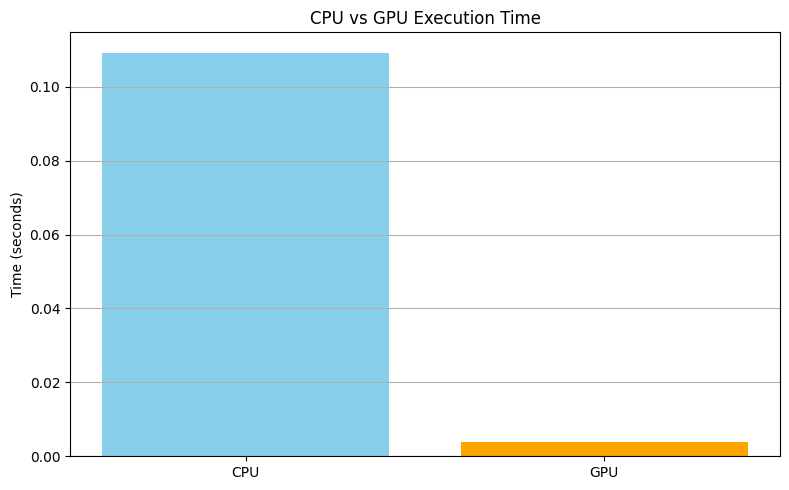

Speedup: 29.22x


In [22]:
import matplotlib.pyplot as plt

# Simulated data
labels = ['CPU', 'GPU']
times = [0.109267, 0.003739]  # example values in seconds

# Bar Plot
plt.figure(figsize=(8, 5))
plt.bar(labels, times, color=['skyblue', 'orange'])
plt.ylabel('Time (seconds)')
plt.title('CPU vs GPU Execution Time')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('execution_time_comparison.png')
plt.show()

# Speedup
speedup = times[0] / times[1]
print(f"Speedup: {speedup:.2f}x")
